# Brazilian E-Commerce EDA

---

## 1. Executive Summary

This notebook aims to present an analytical perspective on the e-commerce landscape in Brazil. The analysis begins with an exploratory data analysis using graphical tools to create informative and easy-to-understand plots. Subsequently, customer reviews are analyzed using Sentiment Analysis and Natural Language Processing techniques to classify the text into sentiment categories. This approach enables us to gain insights into the Brazilian online purchasing behavior and customer sentiment, which can be valuable for businesses operating in this market.

## 2. Data Introduction

From Kaggle : https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_order_reviews_dataset.csv

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners.

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

## 3. Libraries

In [96]:
# Standard libs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ydata_profiling import ProfileReport
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
import json
import requests
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

## 4. Reading the Data


For this task we have differente data sources, each one describing a specific topic related to e-commerce sales. The files are:

olist_customers_dataset.csv

olist_geolocation_dataset.csv

olist_orders_dataset.csv

olist_order_items_dataset.csv

olist_order_payments_dataset.csv

olist_order_reviews_dataset.csv

olist_products_dataset.csv

olist_sellers_dataset.csv

product_category_name_translation.csv

The relationship between these files are described on the documentation. So let's read the datasets and make an initial analysis with all of them. This step will help us a lot to take right decisions in a future exploratory data analysis.

In [97]:
# Reading all files
raw_path = "C:/Users/PC/Documents/BA/Python Data Science/Projects/Brazil/"
olist_customer = pd.read_csv(raw_path + "olist_customers_dataset.csv")
olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')

### 4.1 An Overview from the Data

Before creating a unique dataset with all useful information, let's look at the shape of each dataset, so we can be more assertive on how to use joining statements.

In [98]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame()
data_info["dataset"] = names
data_info["n_rows"] = [df.shape[0] for df in datasets]
data_info["n_cols"] = [df.shape[1] for df in datasets]
data_info["null_amount"] = [df.isnull().sum().sum() for df in datasets]
data_info["qty_null_colums"] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_colums,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,99224,7,145903,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,olist_sellers,3095,4,0,0,


Now let's use a self made function found on the module viz_utils.py for looking at each dataset and bring some detailed parameters about the data content. With this function we can get the following information for each dataset column:

* Column name;

* Null amount;

* Null percentage among the respective dataset;

* Data type;

* total categorical entries;

In [99]:
def data_overview(df):
    # Count number of null values in each column
    qtd_null = df.isnull().sum()
    
    # Calculate percentage of null values in each column
    percent_null = round(qtd_null / len(df) * 100, 2)
    
    # Count number of unique values in each column
    qtd_cat = df.apply(pd.Series.nunique)
    
    # Determine data type of each column
    dtype = df.dtypes
    
    # Create a data frame with the results
    result_df = pd.DataFrame({'feature': df.columns,
                              'qtd_null': qtd_null,
                              'percent_null': percent_null,
                              'qtd_cat': qtd_cat,
                              'dtype': dtype})
    
    return result_df

In [100]:
df_list = [data_overview(df).assign(dataset_name=[name] * df.shape[1]) for name, df in zip(names, datasets)]
df_overview = pd.concat(df_list)
df_overview = df_overview.reset_index(drop=True)
df_overview

,feature,qtd_null,percent_null,qtd_cat,dtype,dataset_name
0,customer_id,0,0.00,99441,object,olist_customer
1,customer_unique_id,0,0.00,96096,object,olist_customer
2,customer_zip_code_prefix,0,0.00,14994,int64,olist_customer
3,customer_city,0,0.00,4119,object,olist_customer
4,customer_state,0,0.00,27,object,olist_customer
5,geolocation_zip_code_prefix,0,0.00,19015,int64,olist_geolocation
6,geolocation_lat,0,0.00,717360,float64,olist_geolocation
7,geolocation_lng,0,0.00,717613,float64,olist_geolocation
8,geolocation_city,0,0.00,8011,object,olist_geolocation
9,geolocation_state,0,0.00,27,object,olist_geolocation


## 5. Exploratory Data Analysis

So now we will go trough an exploratory data analysis to get insights from E-Commerce in Brazil. The aim here is to divide this session into topics so we can explore graphics for each subject (orders, customers, products, items, and others).

### 5.1 Total Orders on E-Commerce

We know that e-commerce is really a growing trend in a global perspective. Let's dive into the orders dataset to see how this trend can be presented in Brazil, at least on the dataset range.

Looking at the dataset columns, we can see orders with different status and with different timestamp columns like purchase, approved, delivered and estimated delivery. First, let's look at the status of the orders we have in this dataset.

---
* How many orders we have for each status?
---

In [101]:
df_orders = olist_orders.merge(olist_customer, how='left', on='customer_id')

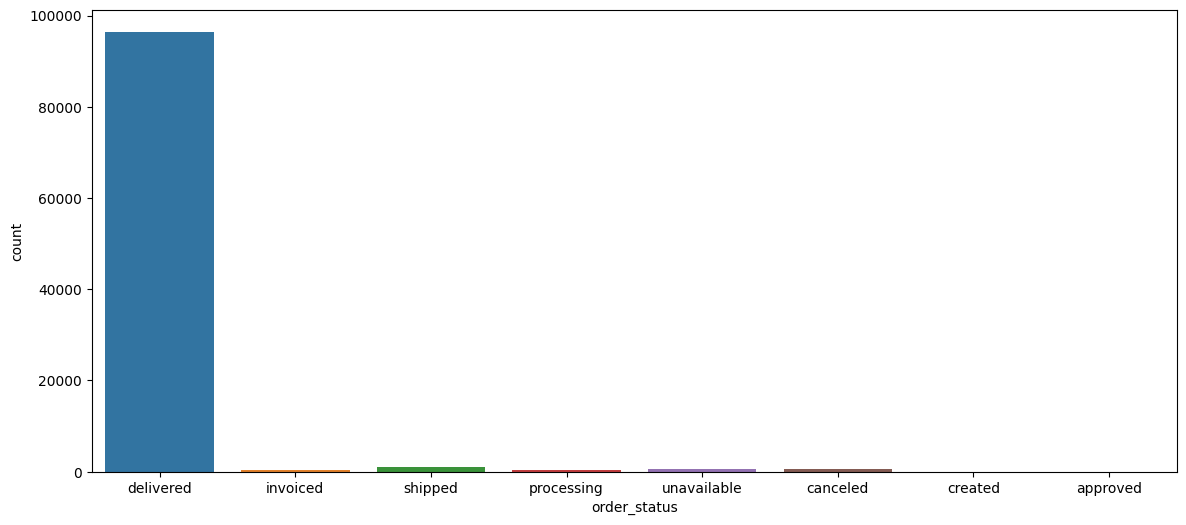

In [102]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.countplot(df_orders, x='order_status', ax=ax)
plt.show()

By the time this dataset was created, the highest amount of orders went from delivered ones. Only 3% of all orders came from the other status.

---
* Is that a growing trend on e-commerce in Brazil? How can we describe a complete scenario?
---

For the next plots, let's dive into the real evolution of e-commerce in terms of purchase orders. For this, we have to extract some info on the order_purchase_timestamp following the topics:

1. Transform timestamp columns;
2. Extract time attributes from these datetime columns (year, month, day, day of week and hour);
3. Evaluate the e-commerce scenario using this attributes.

In [103]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


So now we can purpose a complete analysis on orders amount of brazilian e-commerce during the period of the dataset. For that let's plot three graphs using a GridSpec with the aim answear the following questions:

1. Is there any growing trend on brazilian e-commerce?
2. On what day of week brazilians customers tend to do online purchasing?
3. What time brazilians customers tend do buy (Dawn, Morning, Afternoon or Night)?

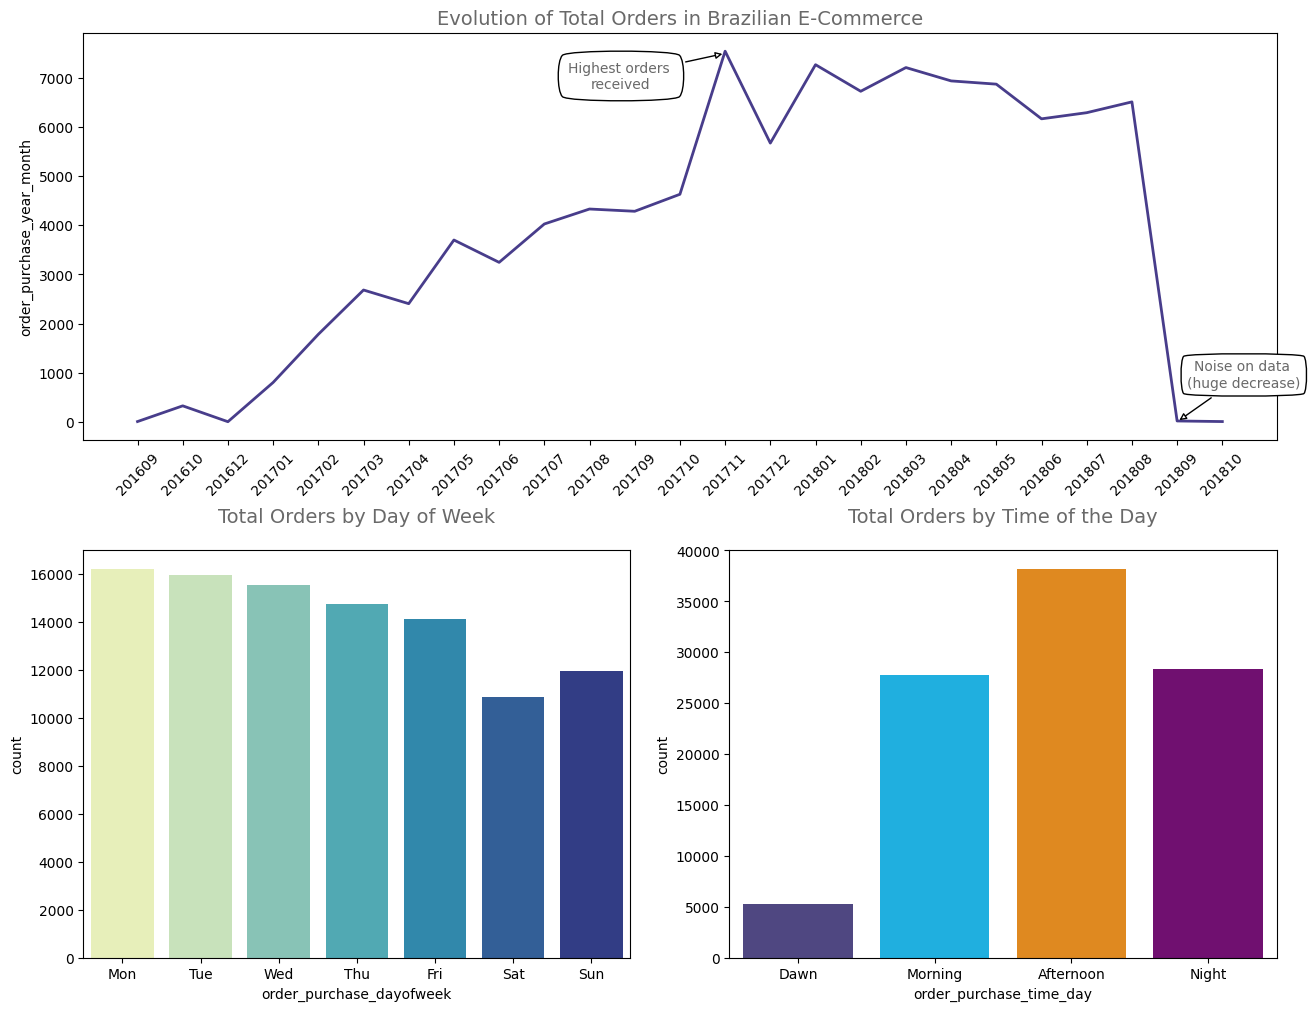

In [104]:
fig = plt.figure(constrained_layout = True, figsize=(13,10))

#Axis definition
gs = GridSpec(2,2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time
sns.lineplot(data = df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
sns.countplot(df_orders, x='order_purchase_dayofweek', ax=ax2, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
sns.countplot(df_orders, x='order_purchase_time_day', ax=ax3, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout
plt.show()

By the chart above we can conclude:

E-commerce on Brazil really has a growing trend along the time. We can see some seasonality with peaks at specific months, but in general we can see clear that customers are more prone to buy things online than before.
Monday are the prefered day for brazilian's customers and they tend to buy more at afternoons.
Obs: we have a sharp decrease between August 2018 and September 2018 and maybe the origin of that is related to noise on data. For further comparison between 2017 and 2018, let's just consider orders between January and August in both years

---
* E-commerce: a comparison between 2017 and 2018
---

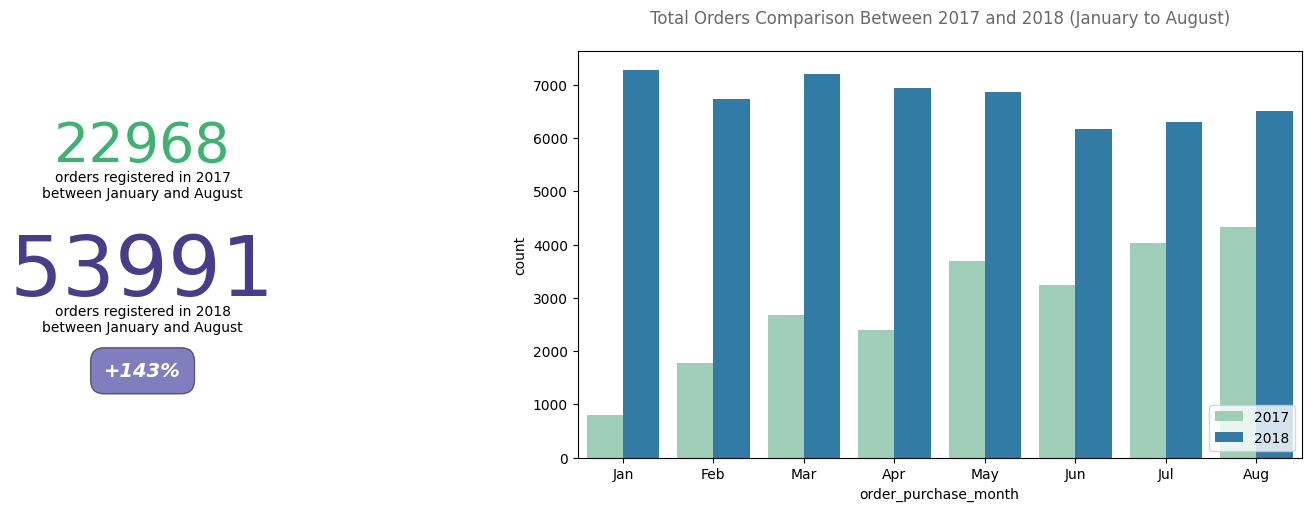

In [105]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
sns.countplot(df_orders_compare, x = 'order_purchase_month',hue='order_purchase_year', ax=ax2,
                 palette='YlGnBu')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Total Orders Comparison Between 2017 and 2018 (January to August)', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')
plt.show()

## 5.2 E-Commerce Around Brazil

For preparing the data to a workaround analysis on brazilian's states e-commerce, we will take the following steps:

1. Merge the orders data to order_items data;
2. Use an API (brazilian government) to return the region of each customer_state;
3. Purpose useful charts to answear business questions.

Brazilian APIs ans links for geolocation info:

https://servicodados.ibge.gov.br/api/docs/localidades?versao=1

There are some outliers coordinates in the dataset that are outside of brazilian territory. Lets guarantee that all coordinates are within a rectangle delimited by the limits of Brazil.

Brazil territory:

The most Northern spot is at 5 deg 16′ 27.8″ N latitude.

The most Western spot is at 73 deg, 58′ 58.19″W Longitude.

The most southern spot is at 33 deg, 45′ 04.21″ S Latitude.

The most Eastern spot is 34 deg, 47′ 35.33″ W Longitude.

The latitude and longitude is stored as numeric format in the olist_geolocation. However, to transform latitude and longitude to a numeric value, we need to convert the degrees, minutes, and seconds to decimal degrees.

In [106]:
olist_geolocation
olist_geolocation[["geolocation_lat", "geolocation_lng"]].head()

,geolocation_lat,geolocation_lng
0,-23.545621,-46.639292
1,-23.546081,-46.644820
2,-23.546129,-46.642951
3,-23.544392,-46.639499
4,-23.541578,-46.641607


In [107]:
# Merging orders and order_items
df_orders_items = df_orders.merge(olist_order_items, how='left', on='order_id')

# Define a function that can convert latitude and longitude into decimal degrees
def angle2dec(angle):
    angle = str(angle)
    x = np.array([y.split() for y in angle.split('\n')]).astype(float)
    x = x[:,0] + x[:,1]/60 + x[:,2]/3600
    return x

lat_north = "5 16 27.8"
lat_south = "33 45 04.21"
long_west = "73 58 58.19"
long_east = "34 47 35.33"

decimal_degrees_north = float(angle2dec(lat_north))
decimal_degrees_south = float(-angle2dec(lat_south))
decimal_degrees_west = float(-angle2dec(long_west))
decimal_degrees_east = float(-angle2dec(long_east))

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= decimal_degrees_north]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= decimal_degrees_west]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= decimal_degrees_south]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  decimal_degrees_east]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,freight_value,id,sigla,nome,nome_regiao,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,8.72,35,SP,São Paulo,Sudeste,3149.0,-23.583885,-46.587473,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,22.76,29,BA,Bahia,Nordeste,47813.0,-12.945892,-45.016313,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,19.22,52,GO,Goiás,Centro-Oeste,75265.0,-16.752735,-48.522139,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,27.20,24,RN,Rio Grande do Norte,Nordeste,59296.0,-5.778488,-35.281450,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,8.72,35,SP,São Paulo,Sudeste,9195.0,-23.760018,-46.524784,santo andre,SP


---
* An overview of customer's order by region, state and city
---

In [108]:
# Filtering data between 201701 and 201808
df_orders_filt = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

# Filtering data between 201701 and 201808
df_regions_group = df_orders_filt.groupby(by=['order_purchase_year_month', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id' : 'count', 'price' : 'sum'}).sort_values(by='order_purchase_year_month')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)
print(df_regions_group.head())

# Grouping data by city (top 10)
df_cities_group = df_orders_filt.groupby(by='geolocation_city', as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]
print(df_cities_group.head())

# Grouping data by state
df_state_group = df_orders_filt.groupby(by='customer_state', as_index=False).count().loc[:, ['customer_state', 'order_id']]
df_state_group = df_state_group.sort_values(by = 'order_id', ascending=False).reset_index(drop=True)
print(df_state_group.head())

    month        region  order_count  order_amount
0  201701  Centro-Oeste           65       8179.76
1  201701      Nordeste           78      10951.37
2  201701         Norte           22       4127.95
3  201701       Sudeste          625      72715.75
4  201701           Sul          176      24338.04
  geolocation_city  order_id
0        sao paulo     17843
1   rio de janeiro      7843
2   belo horizonte      3162
3         brasilia      2203
4         curitiba      1733
  customer_state  order_id
0             SP     47679
1             RJ     14603
2             MG     13168
3             RS      6242
4             PR      5757


Text(0, 0.5, '')

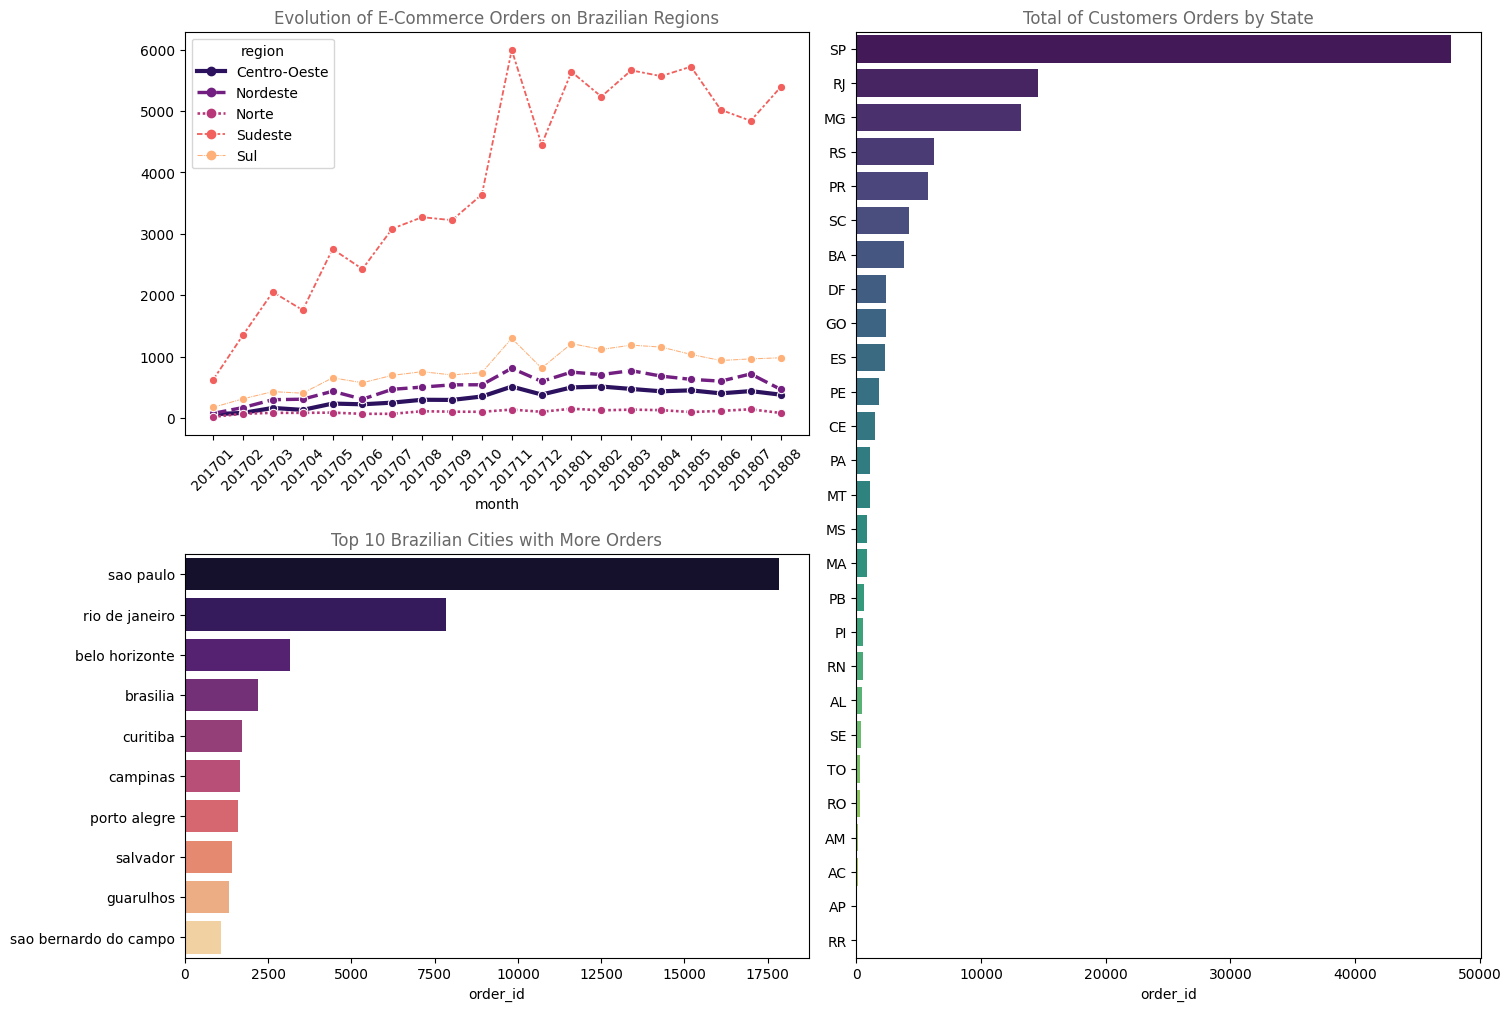

In [109]:
# Creating and preparing figure and axis
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Count of orders by region
sns.lineplot(x='month', y='order_count', ax=ax1, data=df_regions_group, hue='region', 
             size='region', style='region', palette='magma', markers=['o'] * 5)
ax1.set_title('Evolution of E-Commerce Orders on Brazilian Regions', size=12, color='dimgrey')
ax1.set_ylabel('')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Top cities with more customers orders in Brazil
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='magma')
ax2.set_title('Top 10 Brazilian Cities with More Orders', size=12, color='dimgrey')
ax2.set_ylabel('')

# Total orders by state
sns.barplot(y='customer_state', x='order_id', ax=ax3, data=df_state_group, palette='viridis')
ax3.set_title('Total of Customers Orders by State', size=12, color='dimgrey')
ax3.set_ylabel('')

---
* How customers are distributed in Brazil 2018?
---

In [110]:
# Zipping locations
lats = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)
longs = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

---
* HeatMaps: a good view to see where are the core of brazilian e-commerce customers
---

By the map we showed above, we have already the insight that the southeast of Brazil has the highest number of orders given through e-commerce. So, let's see it in a HeatMap!

In [111]:
# Grouping geolocation data for plotting a heatmap
heat_data = df_orders_filt.groupby(by=['geolocation_lat', 'geolocation_lng'], as_index=False).count().iloc[:, :3]

# Creating a mapa using folium
map1 = folium.Map(
    location=[-15, -50], 
    zoom_start=4.0, 
    tiles='cartodbdark_matter'
)

# Plugin: HeatMap
HeatMap(
    name='Mapa de Calor',
    data=heat_data,
    radius=10,
    max_zoom=13
).add_to(map1)

map1

## 5.3 E-Commerce Impact on Economy

Until now, we just answered questions on E-commerce scenario considering the number of orders received. We could see the volumetry amonth months, day of week, time of the day and even the geolocation states.

Now, we will analyze the money movemented by e-commerce by looking at order prices, freights and others.

---
* How about the e-commerce sales? Did they grow up over time?
---

In [112]:
# Grouping data
df_month_aggreg = df_orders_filt.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
    'order_id': 'count',
    'price': 'sum',
    'freight_value': 'sum'
})
# Adding new columns for analysis
df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg = df_month_aggreg.sort_values('order_purchase_year_month')
df_month_aggreg.head()

,order_purchase_year,order_purchase_year_month,order_id,price,freight_value,price_per_order,freight_per_order
0,2017,201701,966,120312.87,16875.62,124.547484,17.469586
1,2017,201702,1998,247303.02,38977.60,123.775285,19.508308
2,2017,201703,3041,374344.30,57704.29,123.099079,18.975432
3,2017,201704,2697,359927.23,52495.01,133.454664,19.464223
4,2017,201705,4176,506071.14,80119.81,121.185618,19.185778


In [113]:
df_month_aggreg['price'].dtype

dtype('float64')

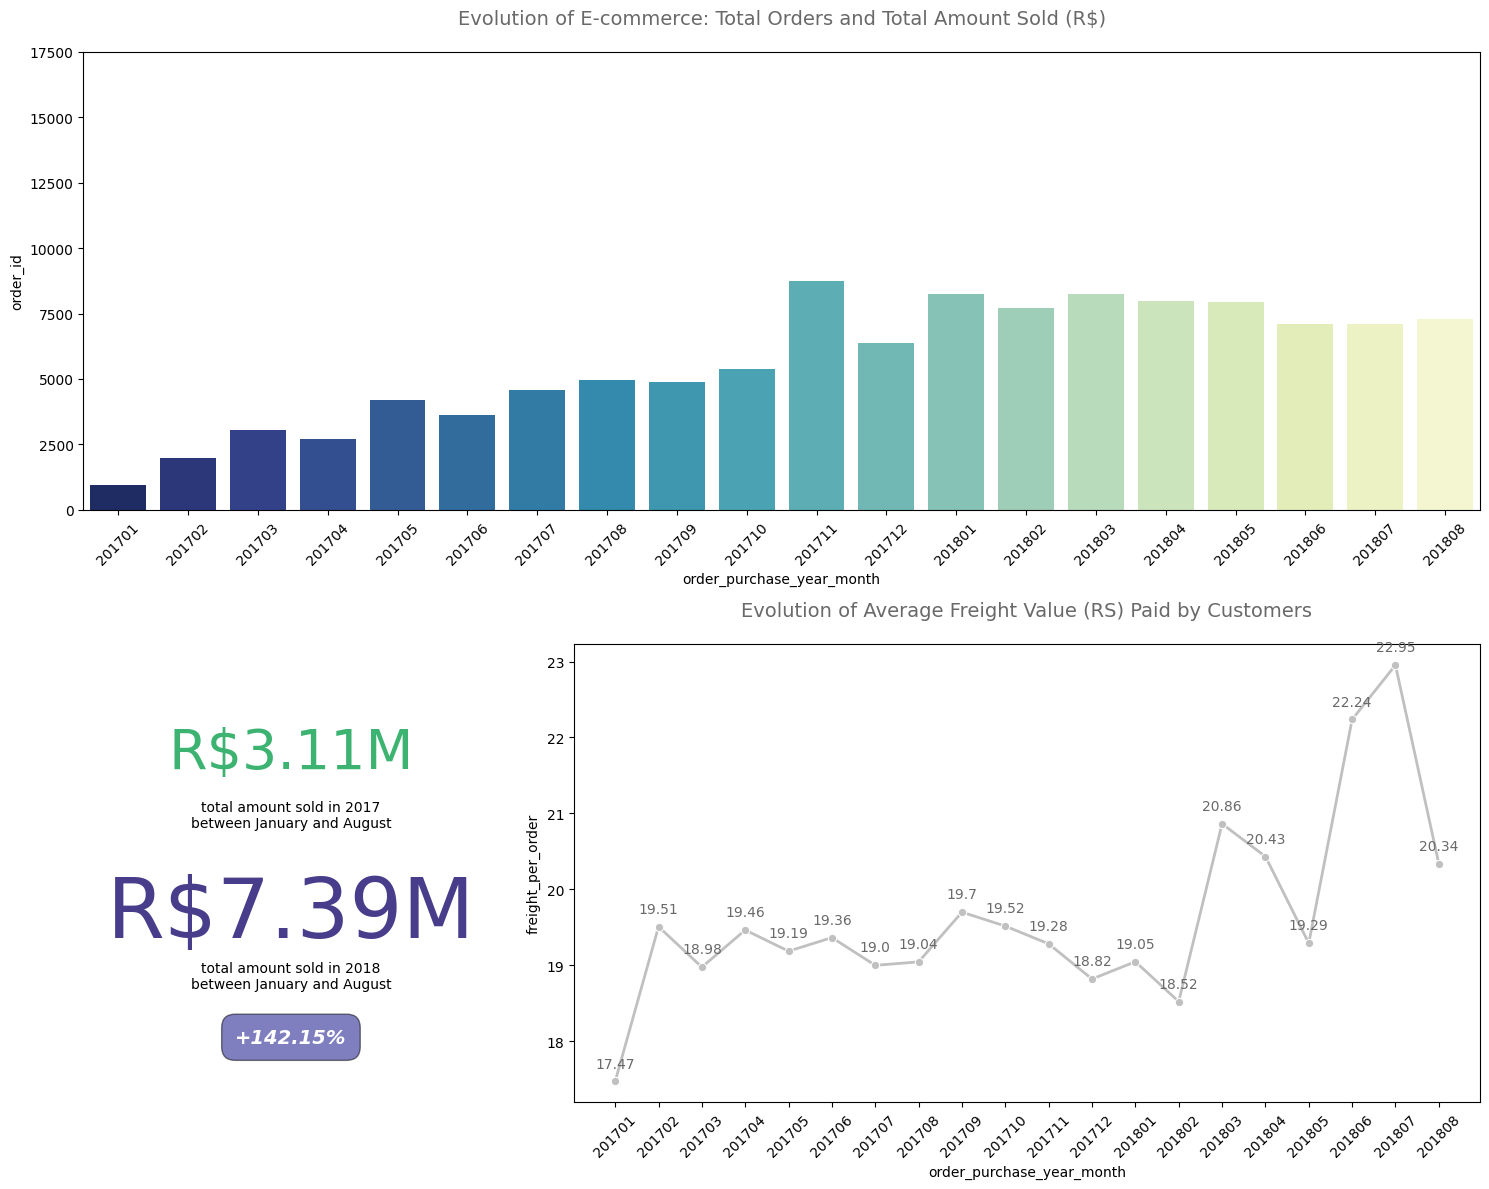

In [124]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.barplot(df_month_aggreg, x='order_purchase_year_month', y = 'order_id', ax=ax1, palette='YlGnBu_r')
ax1.set_yticks(np.arange(0, 20000, 2500))
# Customizing the first plot
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, color='dimgrey', pad=20)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
df_sales_compare = df_month_aggreg.query('order_purchase_year_month in (@month_comparison)')
sold_2017 = df_sales_compare.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = df_sales_compare.query('order_purchase_year == 2018')['price'].sum()
growth = 1 + (sold_2017 / sold_2018)
ax2.text(0.50, 0.73, 'R$' + str(round(sold_2017/1000000, 2)) + 'M', fontsize=40, color='mediumseagreen', ha='center')
ax2.text(0.50, 0.60, 'total amount sold in 2017\nbetween January and August', fontsize=10, ha='center')
ax2.text(0.50, 0.36, 'R$' + str(round(sold_2018/1000000, 2)) + 'M', fontsize=60, color='darkslateblue', ha='center')
ax2.text(0.50, 0.25, 'total amount sold in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Plot 3 - Evolution of mean freight value paid by the customers
sns.lineplot(x='order_purchase_year_month', y='freight_per_order', data=df_month_aggreg, linewidth=2, 
             color='silver', marker='o', ax=ax3)
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.freight_per_order.items():
    ax3.annotate(round(y, 2), xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
ax3.set_title('Evolution of Average Freight Value (RS) Paid by Customers', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

---
* How the total sales (sum of price) are concentraded in brazilian states?
---

<AxesSubplot: xlabel='price', ylabel='customer_state'>

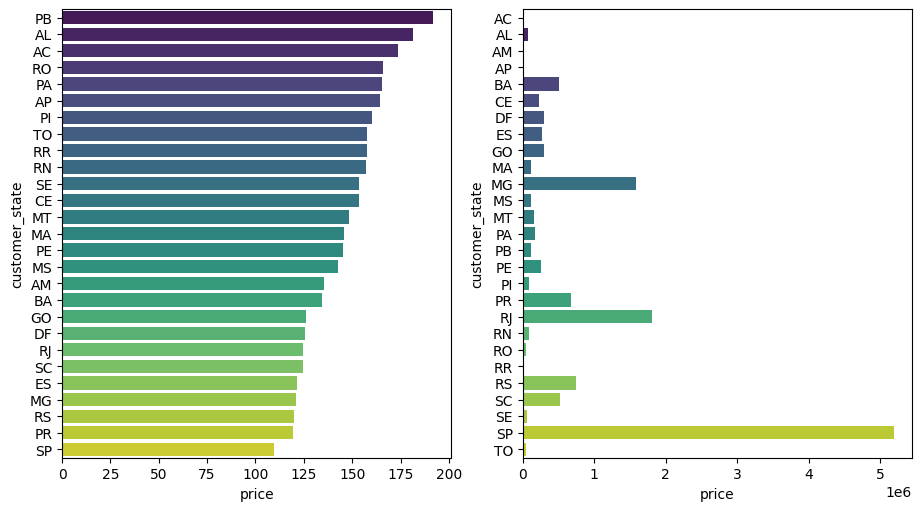

In [154]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
# Axis definition
gs = GridSpec(1, 2, figure=fig)

# plot1 mean price by state
mean_price_state = df_orders_filt.groupby(by='customer_state', as_index=False).mean('price').loc[:, ['customer_state', 'price']]
mean_price_state = mean_price_state.sort_values('price', ascending=False)
sns.barplot(mean_price_state, y = 'customer_state', x = 'price', palette='viridis', ax=ax1)

# plot2 sum price by state
sum_price_state = df_orders_filt.groupby(by='customer_state', as_index=False).sum('price').loc[:, ['customer_state', 'price']]
sns.barplot(sum_price_state, y = 'customer_state', x = 'price', palette='viridis', ax=ax2)

C:\Users\PC\AppData\Local\Temp\ipykernel_26116\934907251.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0.0, 0, '0.0'),
 Text(1000000.0, 0, '1000.0'),
 Text(2000000.0, 0, '2000.0'),
 Text(3000000.0, 0, '3000.0'),
 Text(4000000.0, 0, '4000.0'),
 Text(5000000.0, 0, '5000.0'),
 Text(6000000.0, 0, '6000.0')]

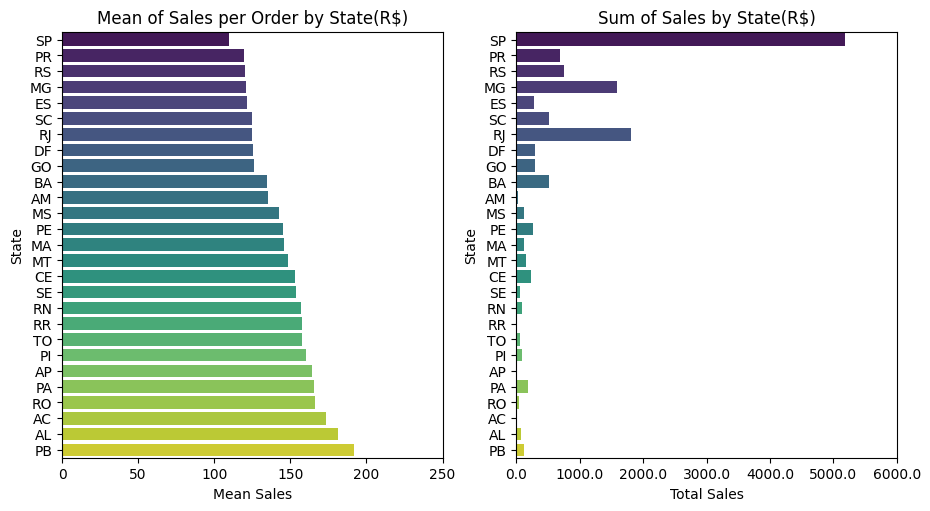

In [159]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
# Axis definition
gs = GridSpec(1, 2, figure=fig)

# group by customer_state, sum price_2, count the number of rows and calculate mean price
orders_price = df_orders_filt.groupby('customer_state').agg(sum_price=('price', 'sum'), count=('price', 'count')).reset_index()
orders_price['mean_price'] = orders_price['sum_price'] / orders_price['count']

# create plot for mean sales
mean_sales = sns.barplot(x='mean_price', y='customer_state', data=orders_price, order=orders_price.sort_values('mean_price')['customer_state'], palette='viridis',ax=ax1)
mean_sales.set(title='Mean of Sales per Order by State(R$)', xlabel='Mean Sales', ylabel='State')
mean_sales.set_xlim([0, 250])

# create plot for total sales
total_sales = sns.barplot(x='sum_price', y='customer_state', data=orders_price, order=orders_price.sort_values('mean_price')['customer_state'], palette='viridis', ax=ax2)
total_sales.set(title='Sum of Sales by State(R$)', xlabel='Total Sales', ylabel='State')
total_sales.set_xlim([0, 6000000])
total_sales.set_xticklabels(total_sales.get_xticks()/1000)